<a href="https://colab.research.google.com/github/sirmammingtonham/projects/blob/main/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In your project, you will pick a dataset and an associated problem that can be solved via
sequence models. You must describe why you need sequence models to solve this problem.
Include a link to the dataset source. Next, you should pick an RNN framework that you would
use to solve this problem (This framework can be in TensorFlow, PyTorch or any other Python
Package). 

I am trying to solve the problem of classifying toxic speech online. I chose a dataset that has examples of toxic and normal comments: https://www.kaggle.com/fizzbuzz/cleaned-toxic-comments.

I will implement my rnns in tensorflow.

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [18]:
SEED = 2010

In [19]:
df = pd.read_csv('data/train_preprocessed.csv')

In [20]:
df.describe()

,identity_hate,insult,obscene,severe_toxic,threat,toxic,toxicity
count,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000,49999.000000
mean,0.008860,0.048981,0.052901,0.010300,0.003360,0.097662,0.222064
std,0.093712,0.215830,0.223838,0.100967,0.057869,0.296860,0.752364
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


<AxesSubplot:ylabel='Frequency'>

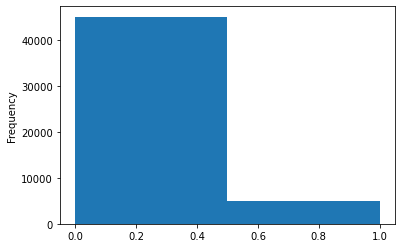

In [42]:
df['toxic'].sort_values().plot.hist(bins=2) # plot label distribution

In [44]:
df['comment_text'].str.split().str.len().describe() # sentence length statistics

count    49999.000000
mean        68.371387
std        101.938259
min          0.000000
25%         17.000000
50%         36.000000
75%         76.000000
max       1403.000000
Name: comment_text, dtype: float64

In [21]:
len(df)

49999

split dataset into training, validation, and test sets using stratified random sampling

In [22]:
trainvalid_df, test_df = train_test_split(df, test_size=0.1, random_state=SEED, stratify=df['toxic'])

In [23]:
train_df, valid_df = train_test_split(trainvalid_df, test_size=0.1, random_state=SEED, stratify=trainvalid_df['toxic'])

#Task 1 (60 points):
###Part 1 (35 points): 
Implement your RNN either using an existing framework OR you can
implement your own RNN cell structure. In either case, describe the structure of your
RNN and the activation functions you are using for each time step and in the output
layer. Define a metric you will use to measure the performance of your model (NOTE:
Performance should be measured both for the validation set and the test set).

In [24]:
import tensorflow as tf
import numpy as np

In [25]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['comment_text'], train_df['toxic']))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_df['comment_text'], valid_df['toxic']))
test_ds = tf.data.Dataset.from_tensor_slices((test_df['comment_text'], test_df['toxic']))

In [26]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

shuffle, batch, and prefetch data

In [27]:
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

setup encoder to tokenize text into vectors for use in rnn

In [28]:
encoder = tf.keras.layers.TextVectorization()
encoder.adapt(train_ds.map(lambda text, label: text))

In [29]:
len(encoder.get_vocabulary())

75804

In [30]:
NUM_LAYERS = 2

In [31]:
model = tf.keras.Sequential([
    encoder, # tokenize input text
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.RNN([
          tf.keras.layers.SimpleRNNCell(64, activation='relu') for _ in range(NUM_LAYERS)
        ])), # bidirectional rnn with relu activation and 2 cells
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [32]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [33]:
history = model.fit(train_ds, epochs=1,
                    validation_data=valid_ds,
                    validation_steps=30)

633/633 [==============================] - 4112s 6s/step - loss: 0.2910 - accuracy: 0.9023 - val_loss: 0.2184 - val_accuracy: 0.8948


In [34]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

79/79 [==============================] - 30s 374ms/step - loss: 0.2033 - accuracy: 0.9024
Test Loss: 0.20326177775859833
Test Accuracy: 0.902400016784668


**ANSWER:** 
I implemented a 2 cell bidirectional rnn with relu activations. Additionally, I tokenized the inputs and added an embedding layer.

I computed classification accuracy on both the training and test set. It took a long time to train, so I had to reduce the epochs to only 1 so I could iterate on the model. Despite this, the accuracy is fairly good, with a validation accuracy of 89% and a higher test set accuracy of 90%, indicating that the model did not overfit.

###Part 2 (25 points): 
Update your network from part 1 with either an LSTM or a GRU
based cell structure. Re-do the training and performance evaluation. What are the
major differences you notice? Why do you think those differences exist between the 2
implementations?


In [35]:
model = tf.keras.Sequential([
    encoder, # tokenize input text
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(64, activation='relu')), # bidirectional GRU with relu activation
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [36]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [37]:
history = model.fit(train_ds, epochs=2,
                    validation_data=valid_ds,
                    validation_steps=30)

Epoch 1/2
633/633 [==============================] - 4973s 8s/step - loss: nan - accuracy: 0.9023 - val_loss: nan - val_accuracy: 0.8990
Epoch 2/2
633/633 [==============================] - 5014s 8s/step - loss: nan - accuracy: 0.9023 - val_loss: nan - val_accuracy: 0.9042


In [38]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

79/79 [==============================] - 41s 522ms/step - loss: nan - accuracy: 0.9024
Test Loss: nan
Test Accuracy: 0.902400016784668


**ANSWER:** 
For this part I used the same general model structure as before, but I swapped the RNN cells for a single GRU cell. 
The accuracy is slightly higher than the simple RNN on the validation set and similar on the test set, though this might be because I was able to train it for an additional epoch since the training time was less overall. I think the reason the performance is fairly similar is since the average length of text in the dataset is fairly small, so the improved long term dependency provided by the GRU is not as needed as in other datasets.

#Task 2 (40 points):
In this task, use any of the pre-trained word embeddings. The Wor2vec embedding link
provided with the lecture notes can be useful to get started. Write your own code/function that
uses these embeddings and outputs cosine similarity and a dissimilarity score for any 2 pair of
words (read as user input). The dissimilarity score should be defined by you. You either can
have your own idea of a dissimilarity score or refer to literature (cite the paper you used). In
either case clearly describe how this score helps determine the dissimilarity between 2 words

In [47]:
import tensorflow_hub as hub

In [48]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
pretrained_embeddings = hub.KerasLayer(module_url) # using pretrained universal sentence encoder embeddings

In [66]:
def similarity_dissimilarity():
  a = str(input('Please enter first word: '))
  b = str(input('Please enter second word: '))
  a_embedding = pretrained_embeddings([a])[0].numpy() # get the embeddings for the word
  b_embedding = pretrained_embeddings([b])[0].numpy()
  sim = np.inner(a_embedding, b_embedding)/(np.linalg.norm(a_embedding)*np.linalg.norm(b_embedding)) # cosine similarity
  dissim = 1 - sim # 1 - cosine similarity, i.e cosine distance
  print(f'Similarity of {a} and {b} is {sim}. (cosine similarity)')
  print(f'Dissimilarity of {a} and {b} is {dissim}. (cosine distance)')
  return sim, dissim

In [67]:
similarity_dissimilarity()

Similarity of hello and hi is 0.9013519287109375. (cosine similarity)
Dissimilarity of hello and hi is 0.0986480712890625. (cosine distance)


(0.9013519, 0.0986480712890625)

**ANSWER**: I defined my dissimilarity score as 1-(cosine similarity), which is equivalent to the cosine distance. I think this is a good measure of dissimilarity since the dissimilarity should be inversely proportional to the similarity, and if two words are dissimilar we can expect them to have a larger distance between the two vectors (larger cosine distance)

# initial pytorch attempt below

I initially tried implementing the rnn in pytorch, but I couldn't find any good resources on passing embeddings to an rnn layer so I decided to switch to tensorflow (it was also really tedious to set up a dataloader in pytorch)

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
  for _, text in data_iter:
    yield tokenizer(text)

In [ ]:
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

In [ ]:
import torch
from torch.utils.data import DataLoader

device = torch.device('cuda')

def collate_batch(batch):
  label_list, text_list, offsets = [], [], [0]
  for (_label, _text) in batch:
    label_list.append(label_pipeline(_label))
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
    text_list.append(processed_text)
    offsets.append(processed_text.size(0))
  label_list = torch.tensor(label_list, dtype=torch.int64)
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
  # print(label_list.shape)
  text_list = torch.cat(text_list)
  return label_list.to(device), text_list.to(device), offsets.to(device)

In [ ]:
from torch import nn

class RNN(nn.Module):
  def __init__(self, input_size, embed_dim, hidden_dim, n_layers):
    super(RNN, self).__init__()

    self.hidden_dim = hidden_dim
    self.n_layers = n_layers

    # start with embedding layer
    self.embedding = nn.EmbeddingBag(input_size, embed_dim, sparse=True)
    # rnn layers
    self.rnn = nn.RNN(embed_dim, hidden_dim, n_layers, batch_first=True, nonlinearity='relu')
    # fully connected layer
    self.fc = nn.Linear(hidden_dim, 2)
    # sigmoid activation
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, x, offsets):
    print(x.shape)
    print(x.size(0))
    # init hidden state
    hidden = self.init_hidden(x.size(0))
    x = self.embedding(x, offsets)
    print(x)
    print(x.shape)
    x, hidden = self.rnn(x, hidden)

    x = x.contiguous().view(-1, self.hidden_dim)
    x = self.fc(x)
    x = self.sigmoid(x) # sigmoid output
    return x, hidden

  def init_hidden(self, batch_size):
    # generate the first hidden state of zeros
    return torch.zeros(self.n_layers, batch_size, self.hidden_dim)

In [ ]:
def train(dataloader):
  model.train()
  total_acc, total_count = 0, 0
  log_interval = 500
  start_time = time.time()

  for idx, (label, text, offsets) in enumerate(dataloader):
    optimizer.zero_grad()
    predicted_label = model(text, offsets)
    loss = criterion(predicted_label, label)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) # try to avoid exploding gradients by clipping
    optimizer.step()
    total_acc += (predicted_label.argmax(1) == label).sum().item()
    total_count += label.size(0)
    if idx % log_interval == 0 and idx > 0:
      elapsed = time.time() - start_time
      print(f'| epoch {epoch:3} | {idx:5}/{len(dataloader):5} batches '
            f'| accuracy {total_acc/total_count:8.3}')
      total_acc, total_count = 0, 0
      start_time = time.time()

In [ ]:
def evaluate(dataloader):
  model.eval()
  total_acc, total_count = 0, 0

  with torch.no_grad():
    for idx, (label, text, offsets) in enumerate(dataloader):
      print(label)
      print(text)
      predicted_label = model(text, offsets)
      loss = criterion(predicted_label, label)
      total_acc += (predicted_label.argmax(1) == label).sum().item()
      total_count += label.size(0)
  return total_acc/(total_count+1)

In [ ]:
# Hyperparameters
EPOCHS = 10
LR = 0.1
BATCH_SIZE = 64

In [ ]:
model = RNN(input_size=len(vocab), embed_dim=64, hidden_dim=12, n_layers=5).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [ ]:
train_dataloader = DataLoader(list(train_iter), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
valid_dataloader = DataLoader(list(valid_iter), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(list(test_iter), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [ ]:
list(train_iter)[0][1]

'  so we basically agree except on the amount of quoting we do  right  my contention is that cutting down those two quotes so drastically misses of crucial information  in the case of krugman  we are missing his justification for calling it astroturfing and in the case of maddow we are excluding her use of the actual word  which seems rather important  '

In [ ]:
next(enumerate(train_dataloader))[1][2]

tensor([   0,   61,   95,  225,  251,  349,  385,  414,  469,  668,  688,  766,
         812,  854,  858,  977, 1022, 1059, 1107, 1143, 1167, 1181, 1197, 1235,
        1342, 1363, 1405, 1452, 1484, 1533, 1615, 1631, 1683, 1689, 1697, 1711,
        1909, 1938, 1968, 2021, 2080, 2093, 2141, 2163, 2183, 2215, 2227, 2280,
        2284, 2330, 2346, 2517, 2533, 2542, 2707, 2713, 2718, 3359, 4147, 4197,
        4219, 4704, 4723, 4748], device='cuda:0')

In [ ]:
import time
total_accu = None

In [ ]:
for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print(f'! end of epoch {epoch:3} ! time: {time.time() - epoch_start_time:5.2}s ! '
          f'valid accuracy {accu_val:8.3} ')
    print('-' * 59)

torch.Size([4794])
4794
tensor([[ 0.1059, -0.0910,  0.0590,  ...,  0.1273,  0.0588, -0.1559],
        [ 0.0111,  0.2785, -0.1334,  ...,  0.1429, -0.0829, -0.2774],
        [-0.1504,  0.2112,  0.1732,  ...,  0.0989, -0.1133, -0.1295],
        ...,
        [-0.0333,  0.4788,  0.1249,  ..., -0.1241, -0.0938, -0.6595],
        [-0.1239,  0.1493, -0.0536,  ..., -0.3682,  0.1406,  0.2889],
        [-0.0159, -0.0856,  0.0706,  ..., -0.0393, -0.0110, -0.0698]],
       device='cuda:0', grad_fn=<EmbeddingBagBackward>)
torch.Size([64, 64])


RuntimeError: ignored